In [1]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        print('bixy,ioxy->boxy: input is', input.shape, 'weights are', weights.shape)
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)
        print('before FFT',x.shape,'after FFT',x_ft.shape)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [25]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        print('shape before concat', x.shape)
        x = self.fc0(x)
        print('shape after concat', x.shape)
        x = x.permute(0, 3, 1, 2)
        #x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        #x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:
################################################################
# configs
################################################################
batch_size = 10
learning_rate = 0.001

epochs = 100
step_size = 100
gamma = 0.5

modes = 12
width = 32

s = 16

In [5]:
################################################################
# load data and data normalization
################################################################
reader = MatReader('./datasets/training_data_16x16_10k')
y_raw = reader.read_field('solution_data')
x_raw = reader.read_field('measurement_data')

ndata = x_raw.shape[0]
x_raw.shape, y_raw.shape

(torch.Size([10000, 128]), torch.Size([10000, 256]))

In [6]:
x_temp = x_raw.reshape(ndata,16,8,1)

In [7]:
x_temp.shape

torch.Size([10000, 16, 8, 1])

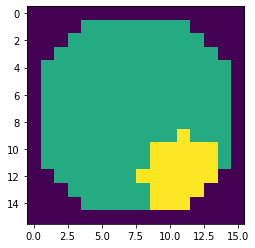

In [8]:
y_temp = y_raw.reshape(ndata,16,16)
plt.imshow(y_temp[1,:,:])


In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw, test_size=0.2, random_state=42)

x_train1 = x_train.reshape(int(0.8*ndata),16,8,1)
x_test1 = x_test.reshape(int(0.2*ndata),16,8,1)

y_train1 = y_train.reshape(int(0.8*ndata),16,16)
y_test1 = y_test.reshape(int(0.2*ndata),16,16)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train1, y_train1), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test1, y_test1), batch_size=batch_size, shuffle=False)

In [10]:
y_train1.shape, y_test1.shape

(torch.Size([8000, 16, 16]), torch.Size([2000, 16, 16]))

In [11]:
x_train1.shape, x_test1.shape

(torch.Size([8000, 16, 8, 1]), torch.Size([2000, 16, 8, 1]))

In [26]:
################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
print(count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
#y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s)
        #out = y_normalizer.decode(out)
        #y = y_normalizer.decode(y)

        loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).reshape(batch_size, s, s)
            #out = y_normalizer.decode(out)

            test_l2 += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_l2, test_l2)


2368130
shape before concat torch.Size([10, 16, 8, 3])
shape after concat torch.Size([10, 16, 8, 32])
before FFT torch.Size([10, 32, 16, 8]) after FFT torch.Size([10, 32, 16, 5])
bixy,ioxy->boxy: input is torch.Size([10, 32, 12, 5]) weights are torch.Size([32, 32, 12, 12])


RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [10, 32, 12, 5]->[10, 1, 12, 5, 32] [32, 32, 12, 12]->[1, 32, 12, 12, 32]

# TESTING STUFF

In [27]:
modes1 = modes2 = modes
in_channels = out_channels = width
scale = (1 / (in_channels * out_channels))

weights1 = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
weights2 = nn.Parameter(scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

# Complex multiplication
def compl_mul2d(input, weights):
    print('bixy,ioxy->boxy: input is', input.shape, 'weights are', weights.shape)
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    return torch.einsum("bixy,ioxy->boxy", input, weights)

In [31]:

batchsize = x.shape[0]
#Compute Fourier coeffcients up to factor of e^(- something constant)
x_ft = torch.fft.rfft2(x)

# Multiply relevant Fourier modes
out_ft = torch.zeros(batchsize, out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat)

print('before FFT',x.shape,'after FFT',x_ft.shape, 'out_ft shape',out_ft.shape)

before FFT torch.Size([10, 16, 8, 1]) after FFT torch.Size([10, 16, 8, 1]) out_ft shape torch.Size([10, 32, 8, 1])


In [30]:
out_ft[:, :, :modes1, :modes2] = \
    compl_mul2d(x_ft[:, :, :modes1, :modes2], weights1)
out_ft[:, :, -modes1:, :modes2] = \
    compl_mul2d(x_ft[:, :, -modes1:, :modes2], weights2)

#Return to physical space
x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

bixy,ioxy->boxy: input is torch.Size([10, 16, 8, 1]) weights are torch.Size([32, 32, 12, 12])


RuntimeError: einsum(): operands do not broadcast with remapped shapes [original->remapped]: [10, 16, 8, 1]->[10, 1, 8, 1, 16] [32, 32, 12, 12]->[1, 32, 12, 12, 32]